In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle

In [3]:
sys.path.append("../..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_gamma_fq_output, load_pion_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi 0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi 0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

## Load fitqun results

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_mapping.pickle'

with open('./prep_data/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

## Load resnet results

In [6]:
############# define run locations #############
short_locs = ['/home/jtindall/WatChMaL/outputs/2021-04-06/13-38-38/outputs']

short_titles = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0], c[1]]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[2], c[3]]
full_linestyle = [':' for _ in range(2)]


In [7]:
############# load short tank run data #############
short_idx_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
short_indices = np.load(short_idx_file_path)['test_idxs']

short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [8]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## e/mu Comparison

### Add fitqun results

In [13]:
fq_scores, fq_labels, fq_mom, fq_masses = load_mu_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [fq_scores]
short_actual_labels  = short_raw_actual_labels + [fq_labels]

### Filter results

In [14]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]


### Plot e/mu comparison

In [15]:
short_collapsed_class_scores_list, short_collapsed_class_labels_list = multi_collapse_test_output(filtered_short_softmax, filtered_labels, label_dict, ignore_type='$\gamma$')

short_collapsed_class_labels_list = [collapsed_class_labels - 1 for collapsed_class_labels in short_collapsed_class_labels_list]
short_collapsed_class_scores_list = [collapsed_class_scores[:,1:] for collapsed_class_scores in short_collapsed_class_scores_list]

In [16]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(short_collapsed_class_scores_list[:-1], short_collapsed_class_labels_list[:-1], 
                            true_label=muon_softmax_index_dict["e/gamma"], 
                            false_label=muon_softmax_index_dict["mu"],
                            normalize=True)

fq_fpr_list, fq_tpr_list, fq_thr_list = multi_compute_roc(short_collapsed_class_scores_list[-1:], short_collapsed_class_labels_list[-1:], 
                            true_label=muon_softmax_index_dict["e/gamma"], 
                            false_label=muon_softmax_index_dict["mu"],
                            normalize=False)

### Combine Results and Plot

In [17]:
############# combine short and long results #############
fpr_list = short_fpr_list + fq_fpr_list
tpr_list = short_tpr_list + fq_tpr_list
thr_list = short_thr_list + fq_thr_list

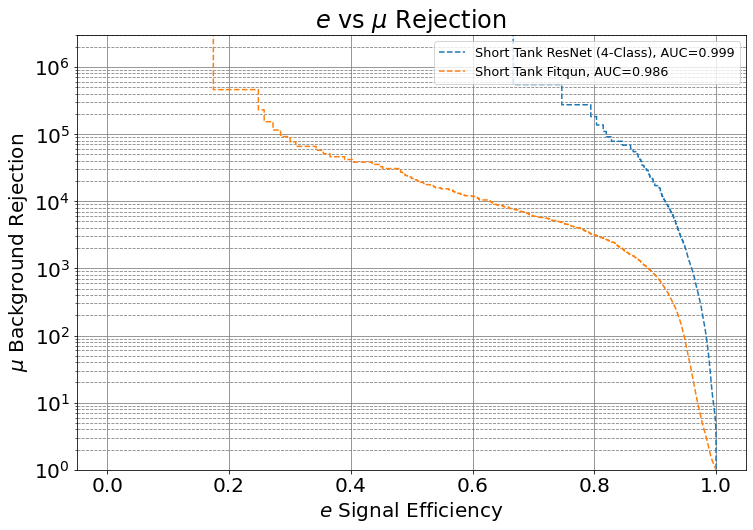

In [18]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\mu$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

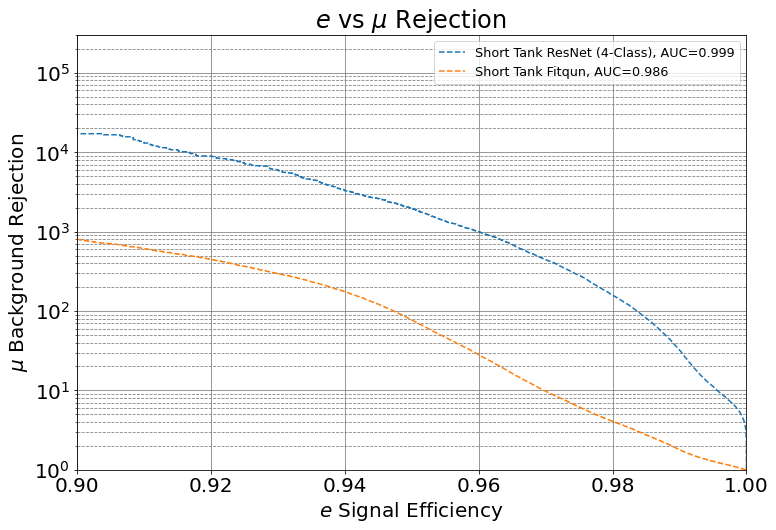

In [19]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\mu$",
                      fig_list=[1], xlims=[[0.9, 1.0]], ylims=[[1,3e5]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

## Plot e/gamma ROC Comparison

### Add fitqun results

In [20]:
gamma_fq_scores_1, gamma_fq_labels_1, _, _ = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_gamma')
gamma_fq_scores_2, gamma_fq_labels_2, _, _ = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')
gamma_fq_scores_3, gamma_fq_labels_3, _, _ = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='gamma_v_mu')

short_output_softmax = short_raw_output_softmax + [gamma_fq_scores_1, gamma_fq_scores_2, gamma_fq_scores_3]
short_actual_labels  = short_raw_actual_labels + [gamma_fq_labels_1, gamma_fq_labels_2, gamma_fq_labels_3]

### Filter results

In [21]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

### Plot All Discriminants

In [22]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(filtered_short_softmax[:1], filtered_labels[:1], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

fq_fpr_list, fq_tpr_list, fq_thr_list = multi_compute_roc(filtered_short_softmax[1:], filtered_labels[1:], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=False)

In [23]:
fpr_list = short_fpr_list + fq_fpr_list
tpr_list = short_tpr_list + fq_tpr_list
thr_list = short_thr_list + fq_thr_list

In [24]:
gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun 1', 'Short Tank Fitqun 2', 'Short Tank Fitqun 3']

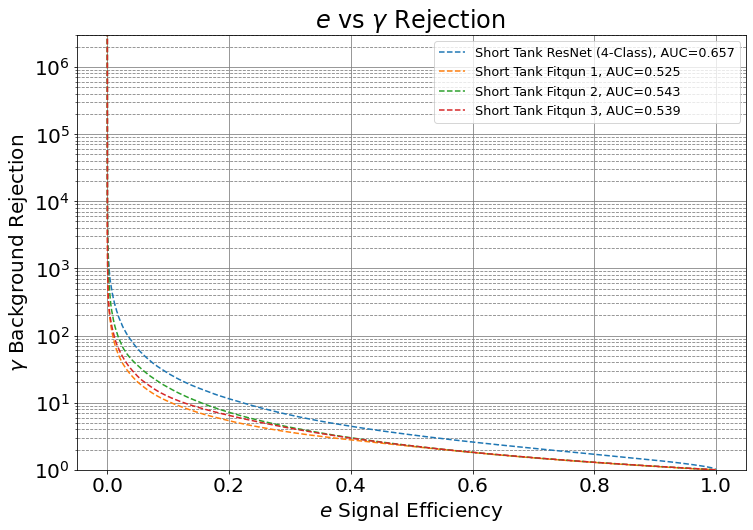

In [25]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

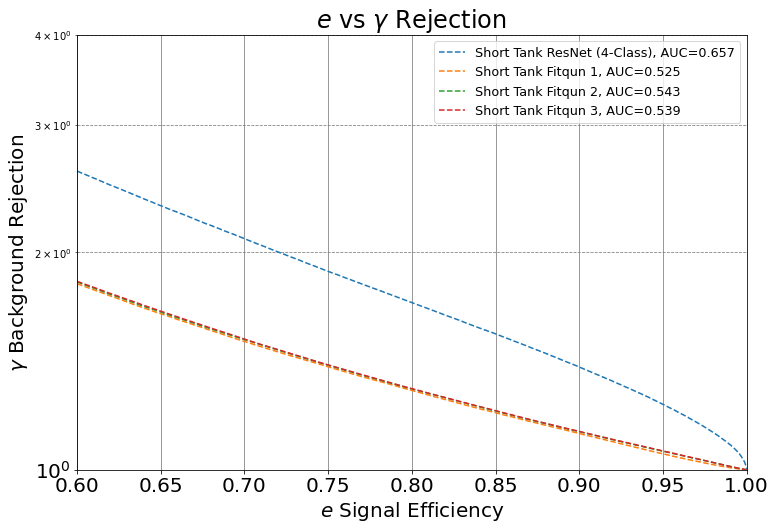

In [26]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

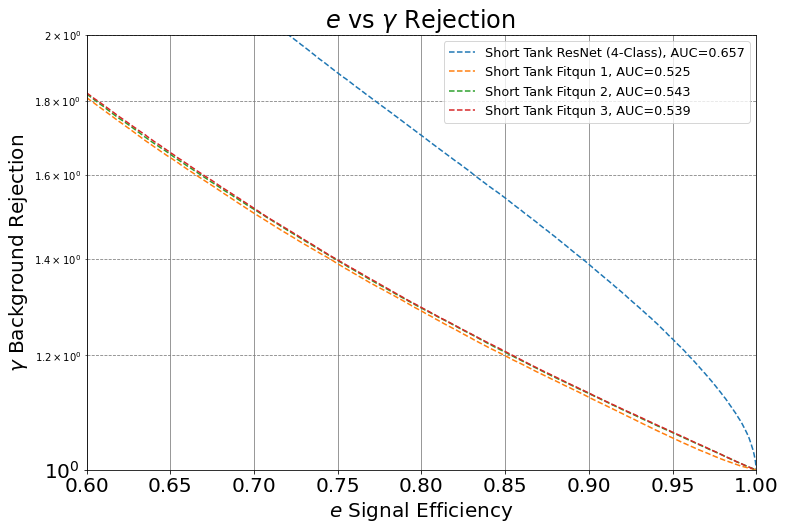

In [27]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,2e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

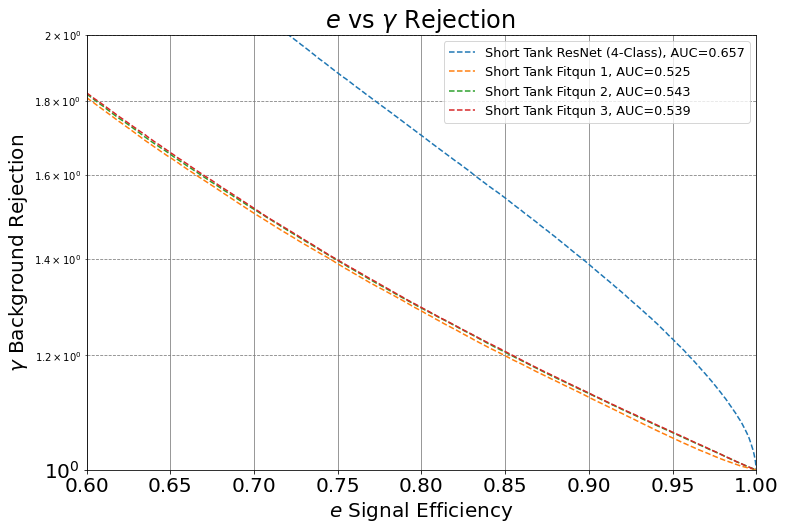

In [28]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,2e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

In [29]:
short_output_softmax = short_raw_output_softmax + [gamma_fq_scores_1] 
short_actual_labels  = short_raw_actual_labels + [gamma_fq_labels_1] 

In [30]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

### Plot All Discriminants

In [31]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(filtered_short_softmax[:1], filtered_labels[:1], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

fq_fpr_list, fq_tpr_list, fq_thr_list = multi_compute_roc(filtered_short_softmax[1:], filtered_labels[1:], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=False)

In [32]:
fpr_list = short_fpr_list + fq_fpr_list
tpr_list = short_tpr_list + fq_tpr_list
thr_list = short_thr_list + fq_thr_list

In [33]:
gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun']

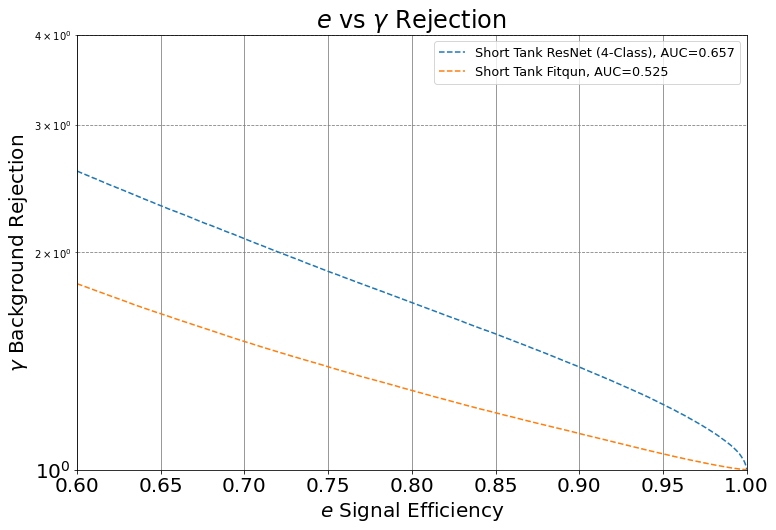

In [34]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=gamma_linestyle,linecolors=gamma_linecolor, plot_labels=gamma_titles, show=False)

## Plot e/Pi0 ROC Comparison (Preliminary)

### Add fitqun results

In [35]:
pion_fq_scores, pion_fq_labels, pion_fq_mom, pion_fq_masses = load_pion_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [pion_fq_scores]
short_actual_labels  = short_raw_actual_labels + [pion_fq_labels]

### Filter results

In [36]:
cut_to_apply = cuts['fq_comparison_pi0']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

In [37]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(filtered_short_softmax[:1], filtered_labels[:1], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\pi 0$"],
                            normalize=True)

fq_fpr_list, fq_tpr_list, fq_thr_list = multi_compute_roc(filtered_short_softmax[1:], filtered_labels[1:], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\pi 0$"],
                            normalize=False)

In [38]:
fpr_list = short_fpr_list + fq_fpr_list
tpr_list = short_tpr_list + fq_tpr_list
thr_list = short_thr_list + fq_thr_list

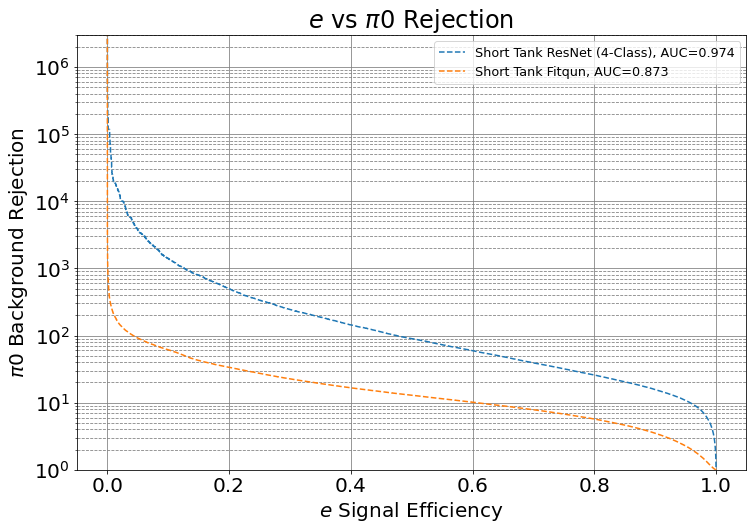

In [39]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\pi 0$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

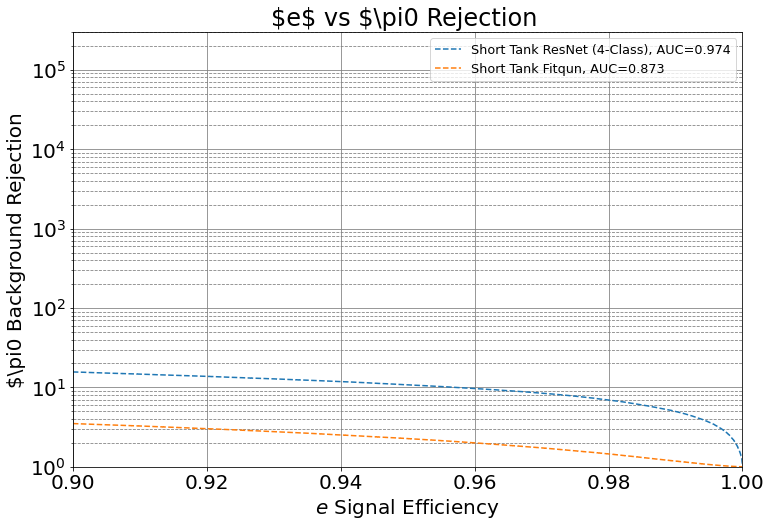

In [40]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\pi0",
                      fig_list=[1], xlims=[[0.9, 1.0]], ylims=[[1,3e5]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)